**Note:** This notebook documents exploratory experiments conducted during model development prior to final design decisions. It includes investigations of thresholding strategies, quadrant aggregation methods, and alternative solver configurations for the Logistic Regression baseline. The experiments provided additional insight during development but are not part of the final pipeline.

In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import Libraries

In [2]:
#main python and data handline libraries
import numpy as np
import pandas as pd
import os

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from transformers import EarlyStoppingCallback

#transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import(AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding)
from typing import List, Dict, Optional

import joblib
import sys

#add project root to Python path to import utils.py
sys.path.append('/content/drive/MyDrive/applied_research_project')
import utils

# 2.Loading data

In [3]:
#load the saved baseline and transformer inputs and targets
save_dir = "/content/drive/MyDrive/applied_research_project/data"

#load TF-IDF features for baseline models
X_train_tfidf = joblib.load(f"{save_dir}/X_train_tfidf.pkl")
X_val_tfidf   = joblib.load(f"{save_dir}/X_val_tfidf.pkl")
X_test_tfidf  = joblib.load(f"{save_dir}/X_test_tfidf.pkl")

#load cleaned text inputs for transformers
X_train_transformer = joblib.load(f"{save_dir}/X_train_transformer.pkl")
X_val_transformer   = joblib.load(f"{save_dir}/X_val_transformer.pkl")
X_test_transformer  = joblib.load(f"{save_dir}/X_test_transformer.pkl")

#load emotion targets
y_train = joblib.load(f"{save_dir}/y_train.pkl")
y_val   = joblib.load(f"{save_dir}/y_val.pkl")
y_test  = joblib.load(f"{save_dir}/y_test.pkl")

In [4]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

mlb = MultiLabelBinarizer()
mlb.classes_ = emotions.iloc[:, 0].values

# 3.Baseline Models

## 3.1. LR Model - Direct Category Training

### 3.1.1. Logistic Regression - Direct Category Training (LBFGS Solver)





In [5]:
#Logistic regression (lbfgs solver, per-label thresholding: min-max based) - Direct Category Training

#map emotions to categories and create category and emotion id mappings
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert train, val, and test emotion labels to category-level labels
y_train_cat=utils.y_to_categories(y_train, categories, cat_to_emoIds)
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

#initialize One-vs-Rest Logistic Regression with lbfgs solver
baseline_lr_lbfgs=OneVsRestClassifier(
    LogisticRegression(
        solver='lbfgs',
        penalty='l2',
        max_iter=10000,
        class_weight='balanced',
        verbose=0
    )
)

#fit the model on train split with category-level labels
baseline_lr_lbfgs.fit(X_train_tfidf, y_train_cat)

#get predicted probabilities from val and test split
val_scores_lr_cat= baseline_lr_lbfgs.predict_proba(X_val_tfidf)
test_scores_lr_cat= baseline_lr_lbfgs.predict_proba(X_test_tfidf)

ts_label = utils.best_thresholds_per_label(val_scores_lr_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False) #get best thresholds per category
ts_baseline = utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val split
utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_label, label_names=categories, title="LR Model with lbfgs Solver (Val Split): Direct Category Training\nPer-Label Thresholds\n")

utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model with lbfgs Solver (Val Split): Direct Category Training\nfixed 0.5 threshold\n")

#evaluate model performance on test split
utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_label, label_names=categories, title="LR Model with lbfgs Solver (Test Split): Direct Category Training\nPer-Label Thresholds\n")

utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model with lbfgs Solver (Test Split): Direct Category Training\nfixed 0.5 Thresholds\n")



LR Model with lbfgs Solver (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.69
Macro F1: 0.66

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.65      0.84      0.73      2341
    pleasant_active       0.73      0.73      0.73      1623
  pleasant_deactive       0.79      0.66      0.72       702
  unpleasant_active       0.47      0.62      0.53       891
unpleasant_deactive       0.54      0.58      0.56       389

          micro avg       0.64      0.74      0.69      5946
          macro avg       0.64      0.69      0.66      5946
       weighted avg       0.65      0.74      0.69      5946
        samples avg       0.68      0.76      0.70      5946


LR Model with lbfgs Solver (Val Split): Direct Category Training
fixed 0.5 threshold

Micro F1: 0.67
Macro F1: 0.64

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous     

### 3.1.2. Logistic Regression - Direct Category Training (Liblinear Solver)

In [6]:
#Logistic regression (liblinear solver, per-label thresholding: min-max based) - Direct Category Training

#initialize One-vs-Rest Logistic Regression with liblinear solver
baseline_lr_liblinear=OneVsRestClassifier(
    LogisticRegression(
         max_iter=1000,
         class_weight='balanced',
         solver='liblinear'
    )
)

baseline_lr_liblinear.fit(X_train_tfidf, y_train_cat)

#get predicted probabilities from val and test splits
val_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_test_tfidf)

ts_label = utils.best_thresholds_per_label(val_scores_lr_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False) #get best thresholds per category
ts_baseline = utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val split
val_metrics_lr=utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_label, label_names=categories, title="LR Model with Liblinear Solver (Val Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model with Liblinear Solver (Val Split): Direct Category Training\nfixed 0.5 threshold\n")

#evaluate model performance on test split
test_metrics_lr=utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_label, label_names=categories, title="LR Model with Liblinear Solver (Test Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model with Liblinear Solver (Test Split): Direct Category Training\nfixed 0.5 threshold\n")



LR Model with Liblinear Solver (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.69
Macro F1: 0.66

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.64      0.86      0.73      2341
    pleasant_active       0.73      0.72      0.73      1623
  pleasant_deactive       0.83      0.63      0.72       702
  unpleasant_active       0.49      0.59      0.53       891
unpleasant_deactive       0.54      0.58      0.56       389

          micro avg       0.65      0.74      0.69      5946
          macro avg       0.65      0.68      0.66      5946
       weighted avg       0.66      0.74      0.69      5946
        samples avg       0.68      0.76      0.70      5946


LR Model with Liblinear Solver (Val Split): Direct Category Training
fixed 0.5 threshold

Micro F1: 0.67
Macro F1: 0.64

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambigu

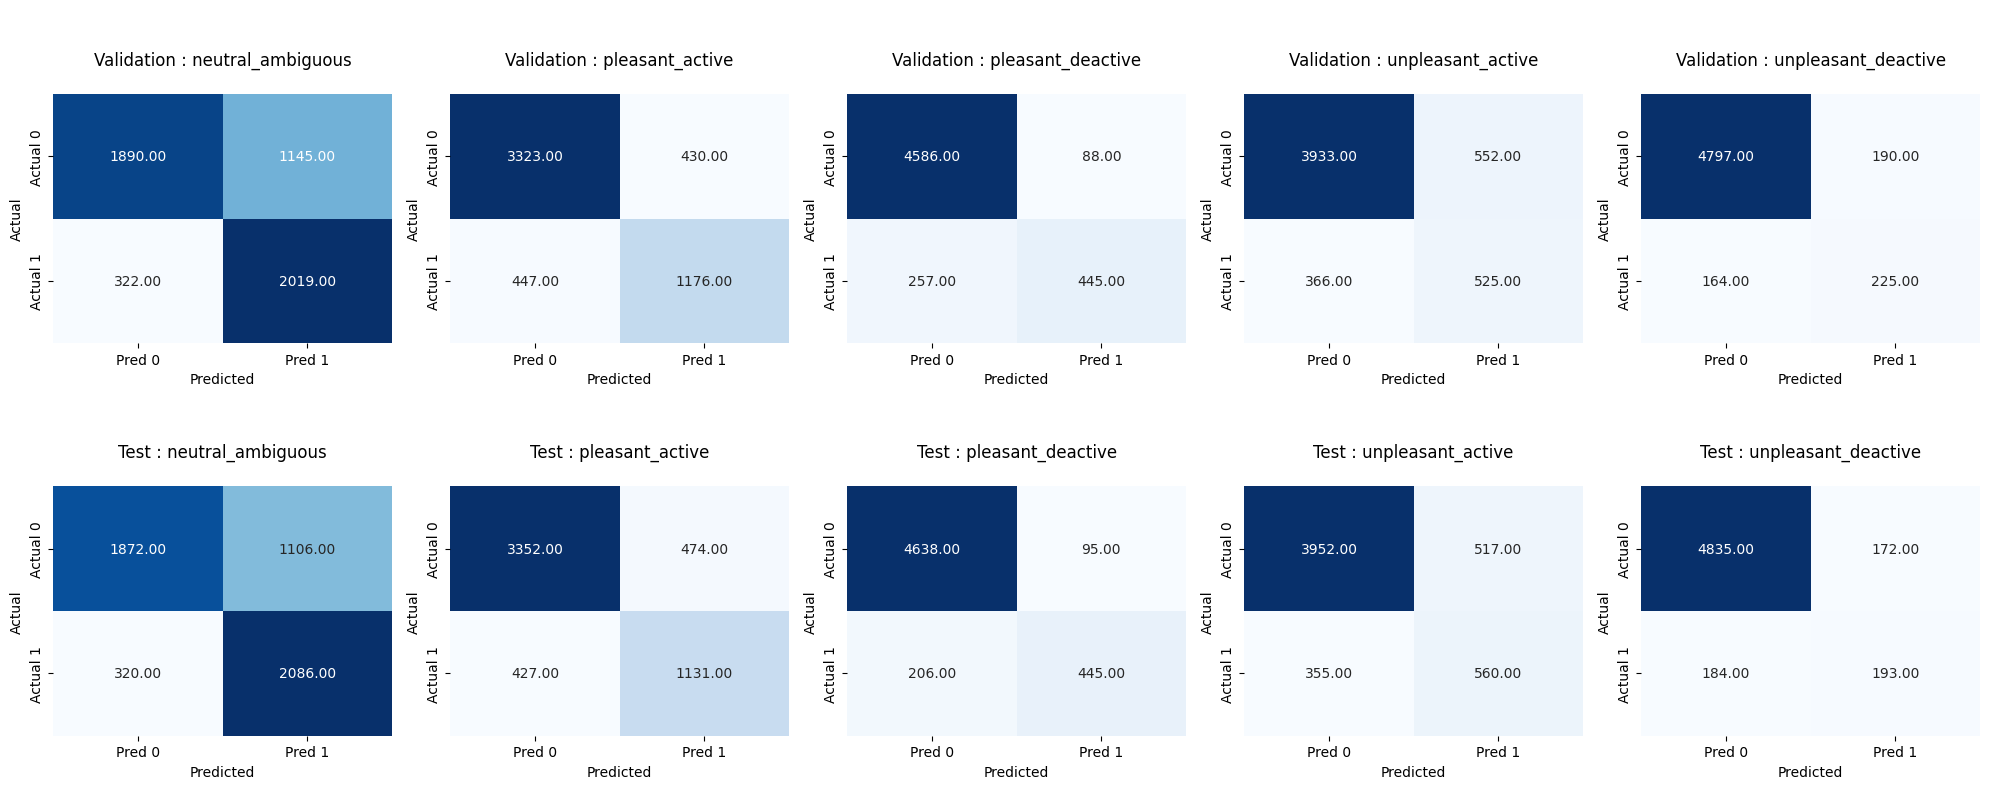

In [7]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_lr_cat, ts_label, categories)

cm_test_lr_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_lr_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_direct_cat, cm_test_lr_direct_cat, categories, normalize=False)

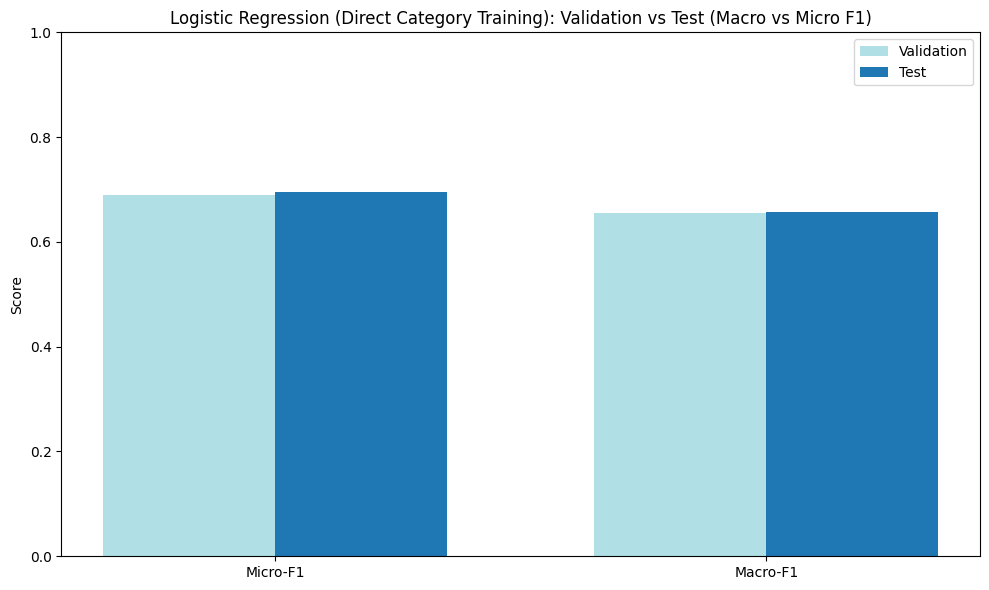

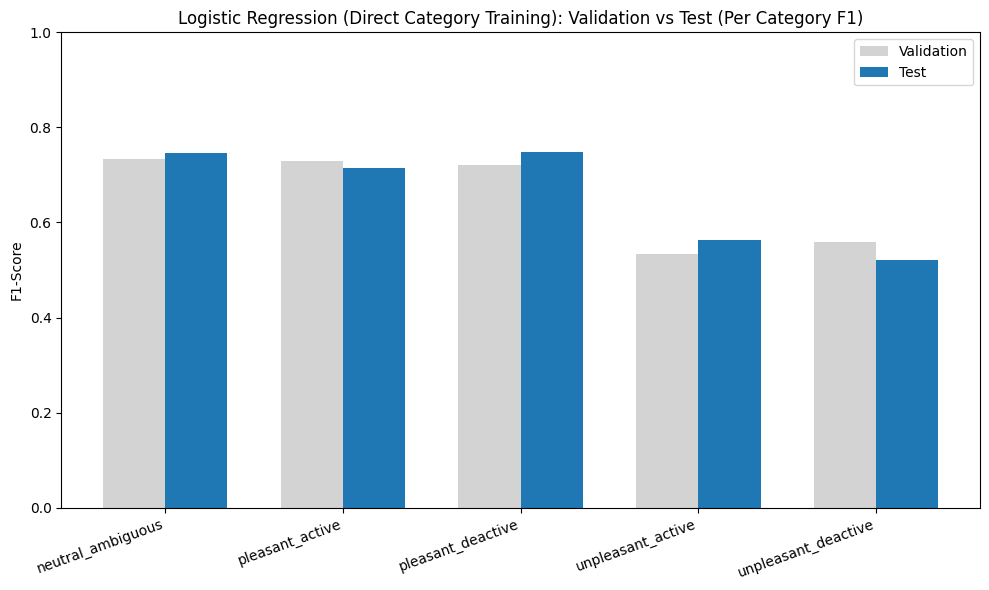

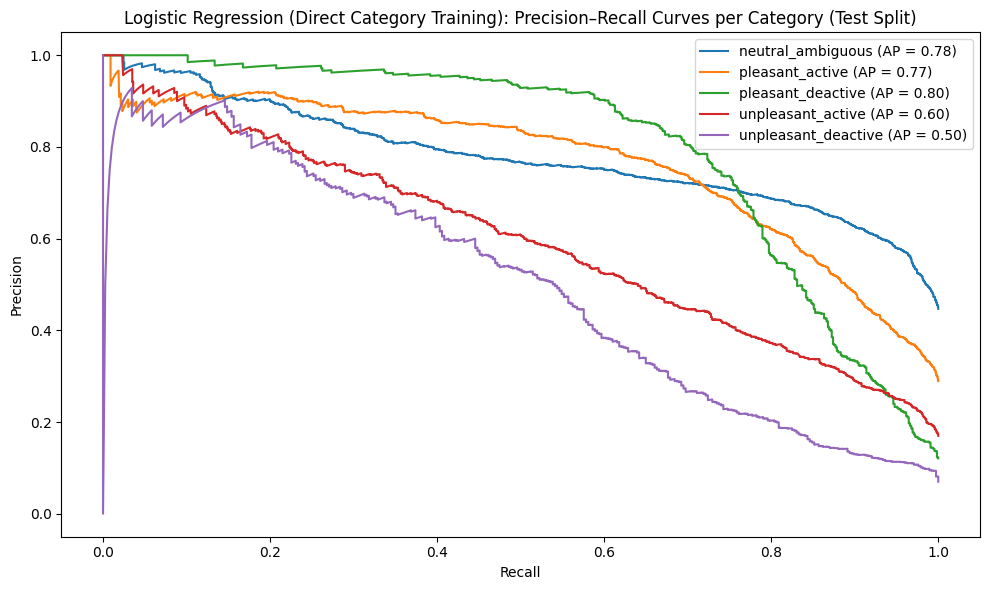

In [8]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr, test_metrics_lr, model_name="Logistic Regression (Direct Category Training)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr, test_metrics_lr, categories, model_name="Logistic Regression (Direct Category Training)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_lr_cat, categories, model_name="Logistic Regression (Direct Category Training)")

## 3.2. LinearSVC -  Direct Category Training

### 3.2.1. LinearSVC -  Direct Category Training (LinearSVC, Per Label Thresholding : Min-Max Based)

In [9]:
#LinearSVC - Direct Category Training

from sklearn.svm import LinearSVC

#initialise the LinearSVC model (One-vs-Rest)
baseline_svc=OneVsRestClassifier(
    LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=5000,
        verbose=0
    )
)

#fit the model on train split using category-level labels
baseline_svc.fit(X_train_tfidf, y_train_cat)

#get raw decision scores from val and test splits
val_scores_svc_cat= np.array(baseline_svc.decision_function(X_val_tfidf))
test_scores_svc_cat= np.array(baseline_svc.decision_function(X_test_tfidf))

ts_label = utils.best_thresholds_per_label(val_scores_svc_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=True) #get best thresholds per category
ts_baseline = utils.baseline_thresholds(y_val_cat)

#convert SVC decision scores to probabilities using sigmoid
val_probs_svc_cat= 1 / (1 + np.exp(-val_scores_svc_cat))
test_probs_svc_cat= 1 / (1 + np.exp(-test_scores_svc_cat))

#evaluate on val split
val_metrics_svc_cat=utils.evaluate_run(y_val_cat, val_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Val Split): Direct Category Training\nper-label threshold", return_metrics=True)
utils.evaluate_run(y_val_cat, val_probs_svc_cat, ts_baseline, label_names=categories, title="LinearSVC (Val Split): Direct Category Training\nfixed 0.5 threshold")

#evaluate on test split
test_metrics_svc_cat=utils.evaluate_run(y_test_cat, test_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Test Split): Direct Category Training\nper-label threshold", return_metrics=True)
utils.evaluate_run(y_test_cat, test_probs_svc_cat, ts_baseline, label_names=categories, title="LinearSVC (Test Split): Direct Category Training\nFixed 0.5 Thresholds")


LinearSVC (Val Split): Direct Category Training
per-label threshold
Micro F1: 0.66
Macro F1: 0.62

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.59      0.89      0.71      2341
    pleasant_active       0.66      0.74      0.70      1623
  pleasant_deactive       0.72      0.66      0.69       702
  unpleasant_active       0.44      0.57      0.50       891
unpleasant_deactive       0.43      0.59      0.50       389

          micro avg       0.58      0.75      0.66      5946
          macro avg       0.57      0.69      0.62      5946
       weighted avg       0.59      0.75      0.66      5946
        samples avg       0.63      0.77      0.67      5946


LinearSVC (Val Split): Direct Category Training
fixed 0.5 threshold
Micro F1: 0.64
Macro F1: 0.61

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.66      0.72      0.69      2341


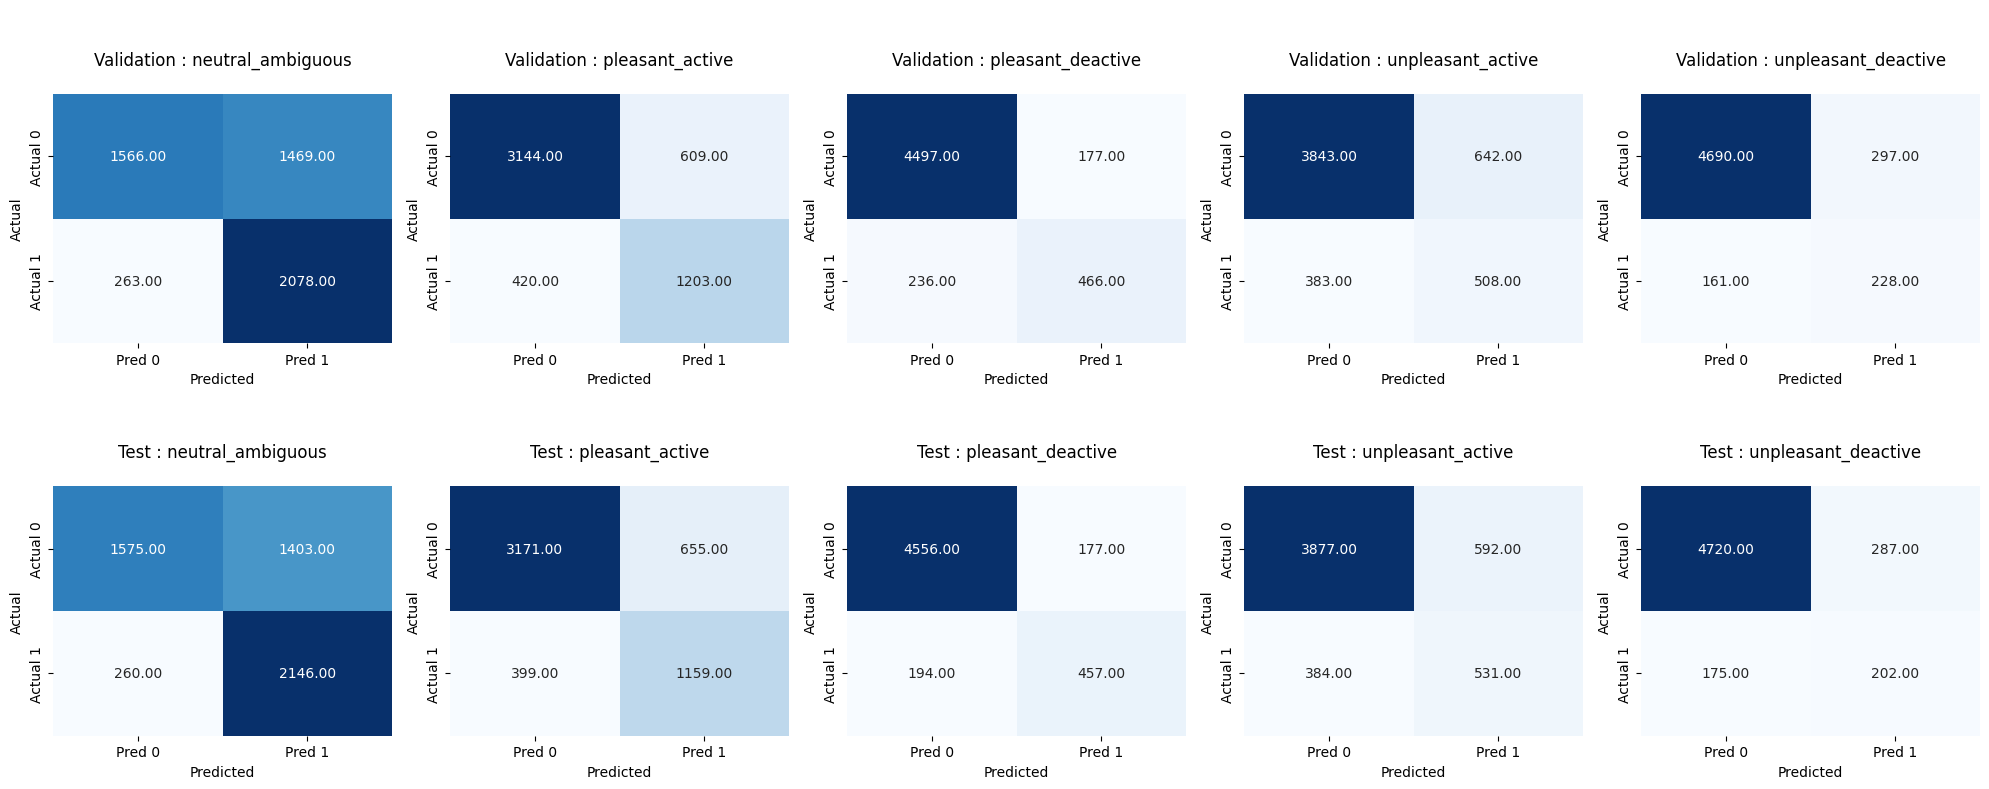

In [10]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_svc_cat, ts_label, categories)

cm_test_svc_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_svc_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_direct_cat, cm_test_svc_direct_cat, categories, normalize=False)

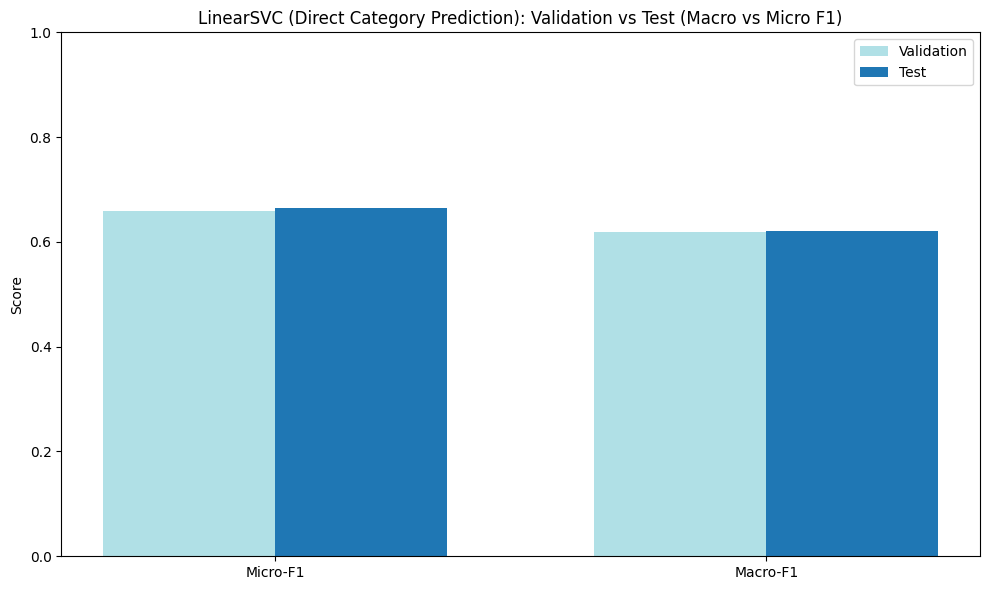

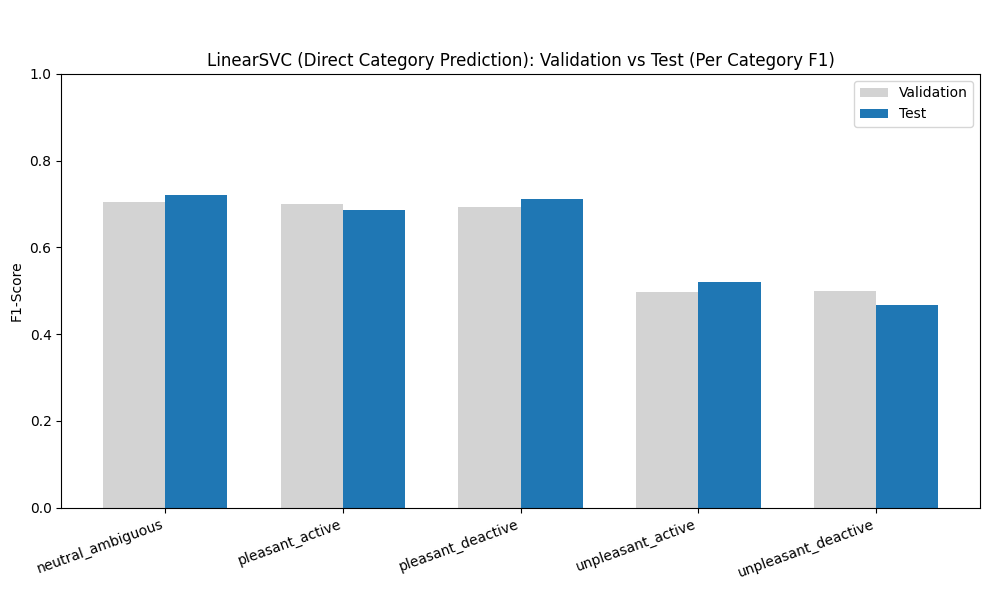

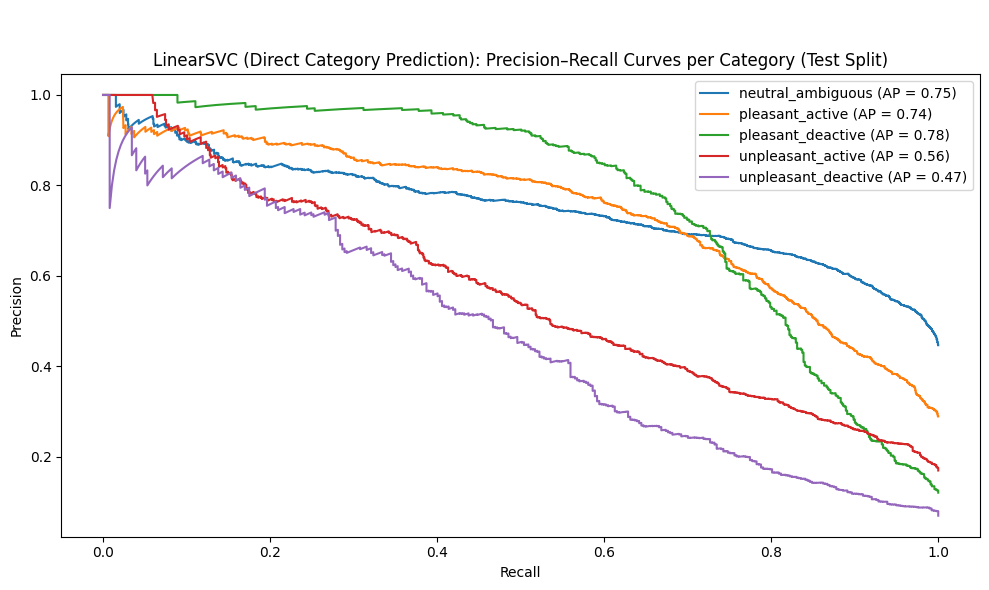

In [11]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_cat, test_metrics_svc_cat, model_name="LinearSVC (Direct Category Prediction)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_cat, test_metrics_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

## 3.3. LR Model -  Per Emotion Prediction to Quadrant Aggregation

### 3.3.1. LR Model - Per-Emotion Prediction (Liblinear Solver, 3 Thresholding Approaches: Min-Max Based)


In [12]:
#logistic regression - liblinear solver , 3 thresholding approaches (min-max based)

#fit model on train split using emotion-level labels
baseline_lr_liblinear.fit(X_train_tfidf, y_train)

#get predicted probabilities from val and test split
val_scores_lr = baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr = baseline_lr_liblinear.predict_proba(X_test_tfidf)

ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=False, scores_are_logits=False) #per emotion threshold
ts_cat=utils.best_thresholds_per_category(val_scores_lr, y_val, emo_to_cat, n_grid=50, use_quantiles=False, scores_are_logits=False) #per category threshold
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=False, scores_are_logits=False, clamp_quantiles=(0.05, 0.95)) #blended threshold
ts_baseline=utils.baseline_thresholds(y_val) #fixed 0.5 threshold

#evaluate model performance on val split
print("\nVal Split: LR Model with liblinear solver (Per Emotion Prediction)")
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Label thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")

#evaluate model performance on test split
print("\nTest Split: LR Model with liblinear solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Label Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")


Val Split: LR Model with liblinear solver (Per Emotion Prediction)

LR + Per-Label thresholds (min-max based)
Micro F1: 0.54
Macro F1: 0.49

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.63      0.72      0.68       485
     amusement       0.66      0.87      0.75       301
         anger       0.39      0.48      0.43       192
     annoyance       0.25      0.40      0.31       303
      approval       0.27      0.36      0.31       394
        caring       0.33      0.38      0.36       152
     confusion       0.25      0.48      0.33       149
     curiosity       0.38      0.77      0.51       247
        desire       0.52      0.52      0.52        77
disappointment       0.18      0.34      0.23       162
   disapproval       0.28      0.32      0.30       292
       disgust       0.42      0.47      0.44        96
 embarrassment       0.47      0.54      0.51        35
    excitement       0.20      0.36      

### 3.3.2. LR Model - Per-Emotion Prediction (Liblinear Solver, 3 Thresholding Approaches: Quantile Based)

In [13]:
#logistic regression - liblinear solver , 3 thresholding approaches (quantile based)

ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=True, scores_are_logits=False) #per emotion threshold
ts_cat=utils.best_thresholds_per_category(val_scores_lr, y_val, emo_to_cat, n_grid=50, use_quantiles=True, scores_are_logits=False) #per category threshold
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=True, scores_are_logits=False, clamp_quantiles=(0.05, 0.95)) #blended threshold
ts_baseline=utils.baseline_thresholds(y_val) #fixed 0.5 threshold

#evaluate model performance on val split
print("\nVal Split: LR Model with liblinear solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Emotion thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_blended, label_names=mlb.classes_, title="LR Test + Blended Thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR Test + Fixed 0.5 Thresholds")

#evaluate model performance on test split
print("\nTest Split: LR Model with liblinear solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Emotion Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")


Val Split: LR Model with liblinear solver (Per Emotion Prediction)


LR + Per-Emotion thresholds (quantile based)
Micro F1: 0.51
Macro F1: 0.43

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.64      0.70      0.67       485
     amusement       0.73      0.77      0.75       301
         anger       0.40      0.44      0.42       192
     annoyance       0.21      0.51      0.30       303
      approval       0.27      0.36      0.31       394
        caring       0.31      0.43      0.36       152
     confusion       0.28      0.40      0.33       149
     curiosity       0.40      0.69      0.51       247
        desire       0.42      0.58      0.49        77
disappointment       0.18      0.35      0.23       162
   disapproval       0.25      0.37      0.30       292
       disgust       0.42      0.47      0.44        96
 embarrassment       0.20      0.63      0.31        35
    excitement       0.17      0.39  

### 3.3.3. Quadrant-Level Evaluation

In [14]:
#convert emotion-level prediction scores to category-level using noisy-or aggregation
val_scores_cat=utils.probs_emo_to_cat(val_scores_lr, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat=utils.probs_emo_to_cat(test_scores_lr, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

ts_quadrant=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, scores_are_logits=False)
ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val and test splits
val_metrics_lr_per_qua=utils.evaluate_run(y_val_cat, val_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Noisy_or Aggregation\n", return_metrics=True)

utils.evaluate_run(y_val_cat, val_scores_cat, ts_baseline, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")

test_metrics_lr_per_qua=utils.evaluate_run(y_test_cat, test_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Noisy_or Aggregation\n", return_metrics=True)

utils.evaluate_run(y_test_cat, test_scores_cat, ts_baseline, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")


LR Model (Val Split): Quadrant Aggregation
Per-Quadrant Thresholds with Noisy_or Aggregation

Micro F1: 0.68
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.90      0.72      2341
    pleasant_active       0.67      0.74      0.71      1623
  pleasant_deactive       0.76      0.69      0.72       702
  unpleasant_active       0.49      0.58      0.53       891
unpleasant_deactive       0.53      0.57      0.55       389

          micro avg       0.61      0.76      0.68      5946
          macro avg       0.61      0.70      0.65      5946
       weighted avg       0.62      0.76      0.68      5946
        samples avg       0.66      0.78      0.69      5946


LR Model (Val Split): Quadrant Aggregation
Fixed 0.5 Thresholds

Micro F1: 0.54
Macro F1: 0.51

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.54      0.

In [15]:
#convert emotion-level prediction scores to category-level using max aggregation
val_scores_cat_max=utils.probs_emo_to_cat(val_scores_lr, categories, cat_to_emoIds, mode="max")
test_scores_cat_max=utils.probs_emo_to_cat(test_scores_lr, categories, cat_to_emoIds, mode="max")

#evaluate model performance on val and test splits
utils.evaluate_run(y_val_cat, val_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Max Aggregation\n", return_metrics=True)

utils.evaluate_run(y_test_cat, test_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Max Aggregation\n", return_metrics=True)


LR Model (Val Split): Quadrant Aggregation
Per-Quadrant Thresholds with Max Aggregation

Micro F1: 0.68
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.90      0.72      2341
    pleasant_active       0.67      0.74      0.71      1623
  pleasant_deactive       0.76      0.69      0.72       702
  unpleasant_active       0.49      0.58      0.53       891
unpleasant_deactive       0.53      0.57      0.55       389

          micro avg       0.61      0.76      0.68      5946
          macro avg       0.61      0.70      0.65      5946
       weighted avg       0.62      0.76      0.68      5946
        samples avg       0.66      0.78      0.69      5946


LR Model (Test Split): Quadrant Aggregation
Per-Quadrant Thresholds with Max Aggregation

Micro F1: 0.69
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguou

{'micro-f1': 0.6862390846130684,
 'macro-f1': 0.6451546488418718,
 'micro-precision': 0.6178663413311645,
 'micro-recall': 0.771626883358727,
 'per_label_f1': array([0.73266655, 0.70238095, 0.72910217, 0.56490872, 0.49671485]),
 'per_label_precision': array([0.6186659 , 0.65482797, 0.73478939, 0.5269631 , 0.4921875 ]),
 'per_label_recall': array([0.89817124, 0.75738126, 0.7235023 , 0.60874317, 0.50132626])}

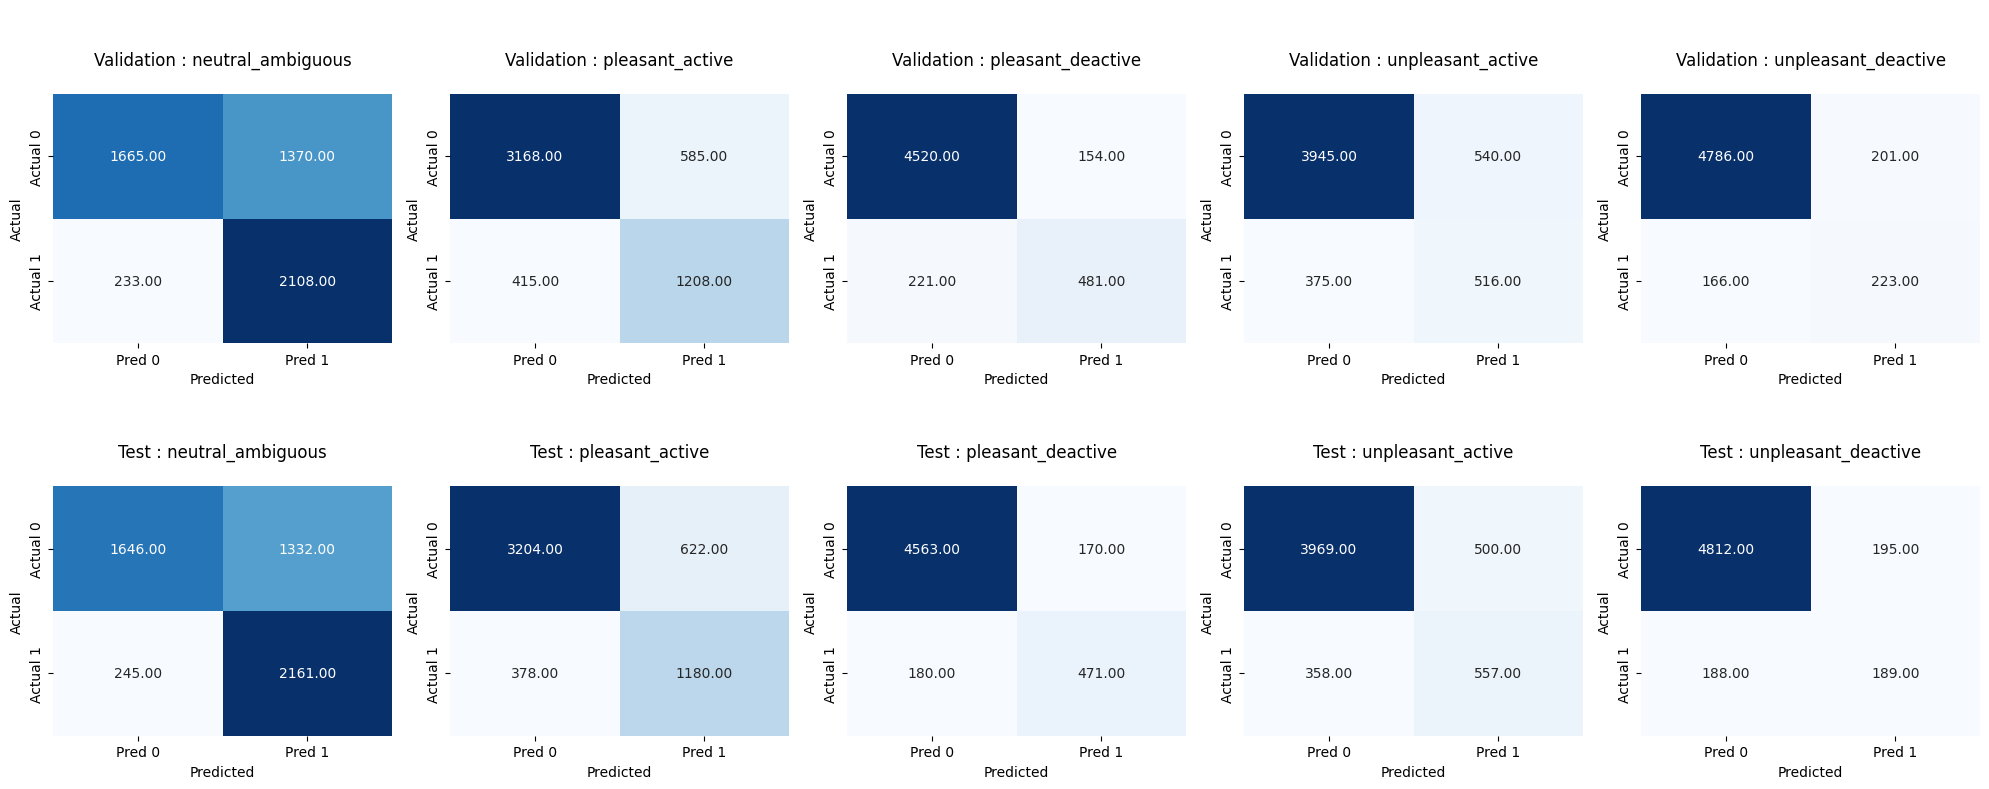

In [16]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_quadrant, categories)

cm_test_lr_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_quadrant, cm_test_lr_quadrant, categories, normalize=False)

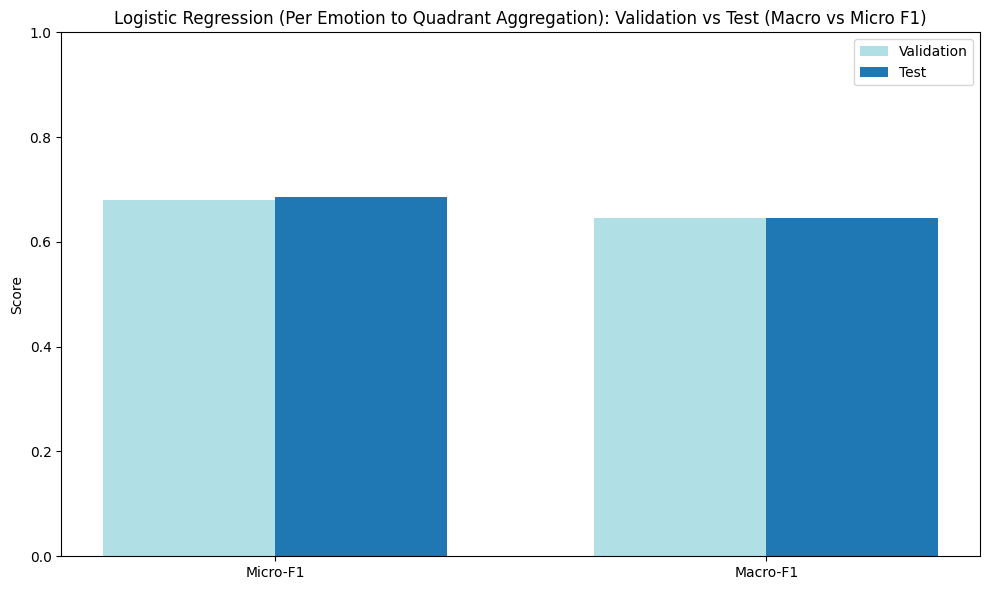

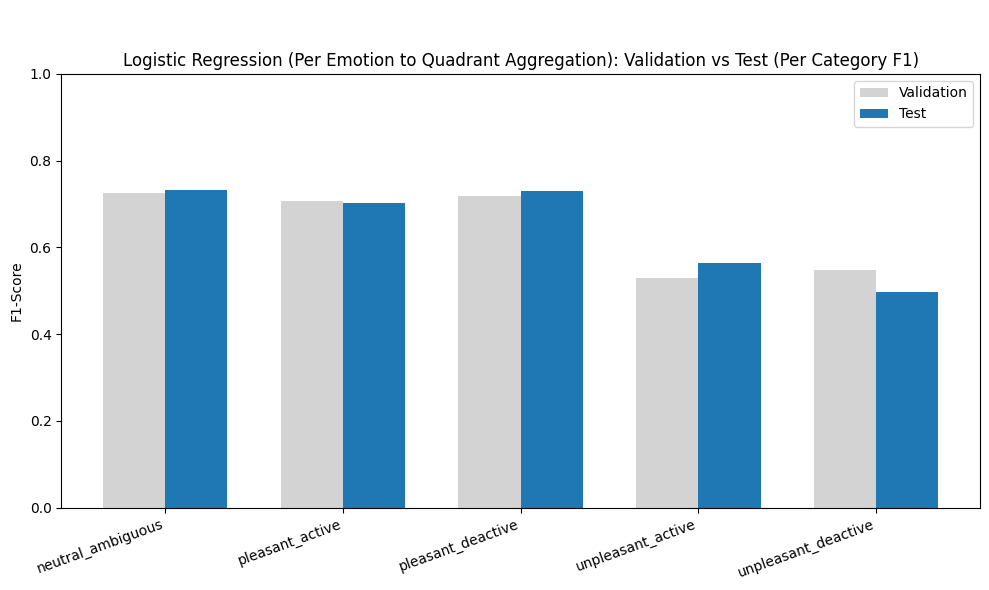

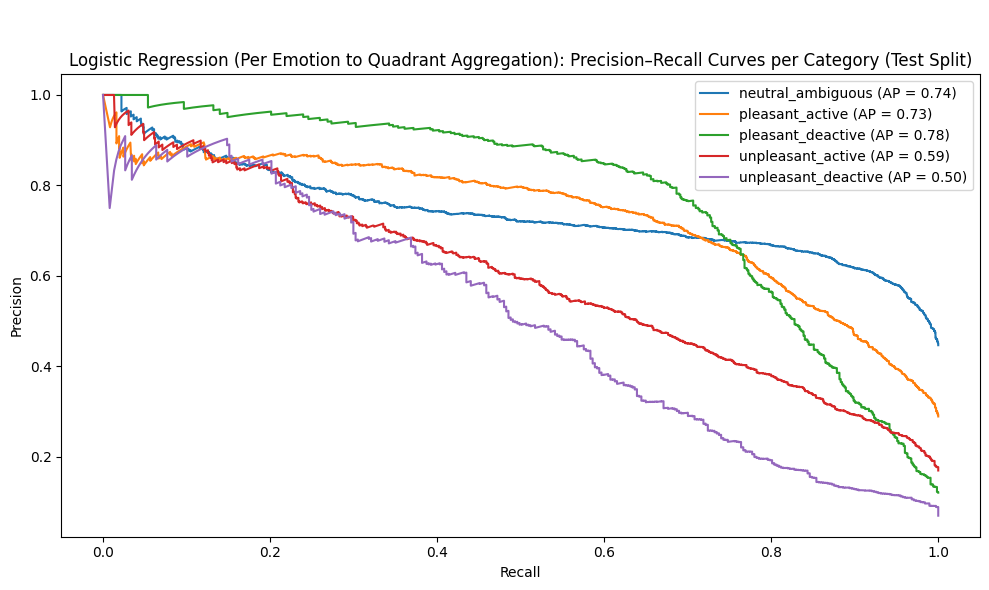

In [17]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr_per_qua, test_metrics_lr_per_qua, model_name="Logistic Regression (Per Emotion to Quadrant Aggregation)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr_per_qua, test_metrics_lr_per_qua, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

**Additional Testing**

### 3.3.4. LR Model - Per-Emotion Prediction (Lbfgs Solver, 3 Thresholding Approaches: Min-Max Based)

In [18]:
#logistic regression - lbfgs solver , 3 thresholding approaches (min-max based)

#fit model on train split using emotion-level labels
baseline_lr_lbfgs.fit(X_train_tfidf, y_train)

#get predicted probabilities from val and test splits
val_scores_lr = baseline_lr_lbfgs.predict_proba(X_val_tfidf)
test_scores_lr = baseline_lr_lbfgs.predict_proba(X_test_tfidf)

ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=False, scores_are_logits=False) #per emotion threshold
ts_cat=utils.best_thresholds_per_category(val_scores_lr, y_val, emo_to_cat, n_grid=50, use_quantiles=False, scores_are_logits=False) #per category threshold
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=False, scores_are_logits=False, clamp_quantiles=(0.05, 0.95)) #blended threshold
ts_baseline=utils.baseline_thresholds(y_val)

#evaluate on val split
print("\nVal Split: LR Model with lbfgs solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Label Thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category Thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (min-max based)")
utils.evaluate_run(y_val, val_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")

#evaluate on test split
print("\nTest Split: LR Model with lbfgs solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Emotion Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (min-max based)")
utils.evaluate_run(y_test, test_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")


Val Split: LR Model with lbfgs solver (Per Emotion Prediction)


LR + Per-Label Thresholds (min-max based)
Micro F1: 0.54
Macro F1: 0.49

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.65      0.70      0.68       485
     amusement       0.77      0.74      0.75       301
         anger       0.40      0.48      0.44       192
     annoyance       0.25      0.40      0.31       303
      approval       0.27      0.37      0.31       394
        caring       0.30      0.44      0.35       152
     confusion       0.25      0.48      0.33       149
     curiosity       0.39      0.76      0.51       247
        desire       0.53      0.51      0.52        77
disappointment       0.20      0.29      0.24       162
   disapproval       0.28      0.34      0.31       292
       disgust       0.45      0.48      0.46        96
 embarrassment       0.47      0.54      0.51        35
    excitement       0.20      0.36      0.2

### 3.3.5. LR Model - Per-Emotion Prediction (Lbfgs Solver, 3 Thresholding Approaches: Quantile Based)

In [19]:
#logistic regression - lbfgs solver , 3 thresholding approaches (quantile based)

ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=True, scores_are_logits=False) #per emotion threshold
ts_cat=utils.best_thresholds_per_category(val_scores_lr, y_val, emo_to_cat, n_grid=50, use_quantiles=True, scores_are_logits=False) #per category threshold
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=True, scores_are_logits=False, clamp_quantiles=(0.05, 0.95)) #blended threshold
ts_baseline=utils.baseline_thresholds(y_val)

#evaluate on val split
print("\nVal Split: LR Model with lbfgs solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Emotion thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (quantile based)")
utils.evaluate_run(y_val, val_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")

#evaluate on test split
print("\nTest Split: LR Model with lbfgs solver (Per Emotion Prediction)\n")
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Emotion Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_cat, label_names=mlb.classes_, title="LR + Per-Category Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_blended, label_names=mlb.classes_, title="LR + Blended Thresholds (quantile based)")
utils.evaluate_run(y_test, test_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR + Fixed 0.5 Thresholds")


Val Split: LR Model with lbfgs solver (Per Emotion Prediction)


LR + Per-Emotion thresholds (quantile based)
Micro F1: 0.52
Macro F1: 0.43

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.65      0.71      0.68       485
     amusement       0.72      0.77      0.75       301
         anger       0.40      0.44      0.42       192
     annoyance       0.21      0.52      0.30       303
      approval       0.27      0.36      0.31       394
        caring       0.30      0.41      0.35       152
     confusion       0.28      0.40      0.33       149
     curiosity       0.40      0.69      0.51       247
        desire       0.42      0.58      0.49        77
disappointment       0.20      0.27      0.23       162
   disapproval       0.29      0.31      0.30       292
       disgust       0.43      0.48      0.45        96
 embarrassment       0.20      0.63      0.31        35
    excitement       0.17      0.39      

## 3.4. LinearSVC -  Per-Emotion Prediction to Quadrant Aggregation

### 3.4.1. LinearSVC - Per-Emotion Prediction (3 Thresholding Approaches: Min-Max Based)


In [20]:
#LinearSVC - Per-Emotion Prediction (3 Thresholding Approaches: Min-Max Based)

#fit model on train split using emotion-level labels
baseline_svc.fit(X_train_tfidf, y_train)

#get raw decision scores from val and test splits
val_scores_svc=np.array(baseline_svc.decision_function(X_val_tfidf))
test_scores_svc=np.array(baseline_svc.decision_function(X_test_tfidf))

ts_label=utils.best_thresholds_per_label(val_scores_svc, y_val, n_grid=50, use_quantiles=False, scores_are_logits=True) #get thresholds per emotion
ts_cat=utils.best_thresholds_per_category(val_scores_svc, y_val, emo_to_cat, n_grid=50, use_quantiles=False, scores_are_logits=True) #get thresholds per category
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=False, scores_are_logits=True, clamp_quantiles=(0.05, 0.95)) #get blended threshold
ts_baseline=utils.baseline_thresholds(y_val)

#apply sigmoid to decsion function for evaluation
val_probs_svc= 1 / (1 + np.exp(-val_scores_svc))
test_probs_svc= 1 / (1 + np.exp(-test_scores_svc))

#evaluate on val split
print("\nLinearSVC Val Set Evaluation (Per-Emotion Prediction)\n")
utils.evaluate_run(y_val, val_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC + Per-Emotion Thresholds (min-max based)")
utils.evaluate_run(y_val, val_probs_svc, ts_cat, label_names=mlb.classes_, title="LinearSVC + Per-Category Thresholds (min-max based)")
utils.evaluate_run(y_val, val_probs_svc, ts_blended, label_names=mlb.classes_, title="LinearSVC + Blended Thresholds (min-max based)")
utils.evaluate_run(y_val, val_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC + Fixed 0.5 Thresholds")

#evaluate on test split
print("\nLinearSVC Test Set Evaluation (Per-Emotion Prediction)\n")
utils.evaluate_run(y_test, test_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC + Per-Emotion Thresholds (min-max based)")
utils.evaluate_run(y_test, test_probs_svc, ts_cat, label_names=mlb.classes_, title="LinearSVC + Per-Category Thresholds (min-max based)")
utils.evaluate_run(y_test, test_probs_svc, ts_blended, label_names=mlb.classes_, title="LinearSVC + Blended Thresholds (min-max based)")
utils.evaluate_run(y_test, test_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC + Fixed 0.5 Thresholds")


LinearSVC Val Set Evaluation (Per-Emotion Prediction)


LinearSVC + Per-Emotion Thresholds (min-max based)
Micro F1: 0.49
Macro F1: 0.43

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.62      0.61      0.62       485
     amusement       0.72      0.80      0.75       301
         anger       0.40      0.38      0.39       192
     annoyance       0.20      0.37      0.25       303
      approval       0.22      0.36      0.27       394
        caring       0.23      0.39      0.29       152
     confusion       0.23      0.44      0.30       149
     curiosity       0.43      0.47      0.45       247
        desire       0.45      0.52      0.48        77
disappointment       0.13      0.31      0.19       162
   disapproval       0.29      0.23      0.25       292
       disgust       0.30      0.52      0.38        96
 embarrassment       0.36      0.46      0.41        35
    excitement       0.18      0.26      0.2

### 3.4.2. LinearSVC - Per-Emotion Prediction (3 Thresholding Approaches: Quantile Based)

In [21]:
#LinearSVC - Per-Emotion Prediction (3 Thresholding Approaches: quantile Based)
ts_label=utils.best_thresholds_per_label(val_scores_svc, y_val, n_grid=50, use_quantiles=True, scores_are_logits=True) #get thresholds per emotion
ts_cat=utils.best_thresholds_per_category(val_scores_svc, y_val, emo_to_cat, n_grid=50, use_quantiles=True, scores_are_logits=True) #get thresholds per category
ts_blended=utils.best_thresholds_blended(val_scores_lr, y_val, emo_to_cat, k=100, n_grid=50, use_quantiles=True, scores_are_logits=True, clamp_quantiles=(0.05, 0.95)) #get blended threshold
ts_baseline=utils.baseline_thresholds(y_val)

print("\nLinearSVC Val Set Evaluation\n")
utils.evaluate_run(y_val, val_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC Val + Per-Emotion Thresholds (quantile based))")
utils.evaluate_run(y_val, val_probs_svc, ts_cat, label_names=mlb.classes_, title="LinearSVC Val + Per-Category Thresholds (quantile based))")
utils.evaluate_run(y_val, val_probs_svc, ts_blended, label_names=mlb.classes_, title="LinearSVC Val + Blended Thresholds (quantile based))")
utils.evaluate_run(y_val, val_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC Val + Fixed 0.5 Thresholds")

print("\nLinearSVC Test Set Evaluation\n")
utils.evaluate_run(y_test, test_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC Test + Per-Emotion Thresholds (quantile based))")
utils.evaluate_run(y_test, test_probs_svc, ts_cat, label_names=mlb.classes_, title="LinearSVC Test + Per-Category Thresholds (quantile based))")
utils.evaluate_run(y_test, test_probs_svc, ts_blended, label_names=mlb.classes_, title="LinearSVC Test + Blended Thresholds (quantile based))")
utils.evaluate_run(y_test, test_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC Test + Fixed 0.5 Thresholds")


LinearSVC Val Set Evaluation


LinearSVC Val + Per-Emotion Thresholds (quantile based))
Micro F1: 0.47
Macro F1: 0.39

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.58      0.64      0.61       485
     amusement       0.73      0.77      0.75       301
         anger       0.36      0.40      0.38       192
     annoyance       0.18      0.39      0.25       303
      approval       0.22      0.36      0.27       394
        caring       0.21      0.44      0.28       152
     confusion       0.22      0.48      0.30       149
     curiosity       0.39      0.50      0.44       247
        desire       0.38      0.53      0.44        77
disappointment       0.13      0.35      0.19       162
   disapproval       0.30      0.22      0.25       292
       disgust       0.33      0.38      0.35        96
 embarrassment       0.19      0.60      0.29        35
    excitement       0.13      0.45      0.20        94
       

### 3.4.3. LinearSVC- Quadrant-Level Evaluation

In [22]:
#Quadrant-Level Evaluation with Noisy_or Aggregation

#convert emotion-level prediction scores to category-level using noisy-or aggregation
val_probs_cat_svc=utils.probs_emo_to_cat(val_probs_svc, categories, cat_to_emoIds, mode="noisy_or")
test_probs_cat_svc=utils.probs_emo_to_cat(test_probs_svc, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat  = utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat = utils.y_to_categories(y_test, categories, cat_to_emoIds)

#find optimal thresholds for each emotion category using val data
ts_quadrant=utils.best_thresholds_per_label(val_probs_cat_svc, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)
ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val and test splits
val_metrics_svc_per_emo=utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_baseline, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")

test_metrics_svc_per_emo=utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nPer-Quadrant Thresholds with Noisy_or Aggregation", return_metrics=True)
utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_baseline, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nFixed 0.5 Thresholds")


LinearSVC (Val Split): Quadrant Aggregation
Per-Quadrant Thresholds with Noisy_or Aggregation

Micro F1: 0.64
Macro F1: 0.60

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.84      0.70      2341
    pleasant_active       0.59      0.73      0.65      1623
  pleasant_deactive       0.70      0.65      0.67       702
  unpleasant_active       0.40      0.62      0.48       891
unpleasant_deactive       0.43      0.58      0.49       389

          micro avg       0.56      0.74      0.64      5946
          macro avg       0.54      0.68      0.60      5946
       weighted avg       0.57      0.74      0.64      5946
        samples avg       0.60      0.75      0.65      5946


LinearSVC (Val Split): Quadrant Aggregation
Fixed 0.5 Thresholds

Micro F1: 0.37
Macro F1: 0.35

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.44      

In [23]:
#quadrant-Level Evaluation with max Aggregation

#convert emotion-level prediction scores to category-level using max aggregation
val_probs_cat_svc=utils.probs_emo_to_cat(val_probs_svc, categories, cat_to_emoIds, mode="max")
test_probs_cat_svc=utils.probs_emo_to_cat(test_probs_svc, categories, cat_to_emoIds, mode="max")

#convert target labels from emotion-level to category-level
y_val_cat  = utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat = utils.y_to_categories(y_test, categories, cat_to_emoIds)

#find optimal thresholds for each emotion category using val data
ts_quadrant=utils.best_thresholds_per_label(val_probs_cat_svc, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)
ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val and test splits
utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nPer-Quadrant Thresholds with max Aggregation\n", return_metrics=True)

utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nPer-Quadrant Thresholds with max Aggregation", return_metrics=True)


LinearSVC (Val Split): Quadrant Aggregation
Per-Quadrant Thresholds with max Aggregation

Micro F1: 0.64
Macro F1: 0.60

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.59      0.86      0.70      2341
    pleasant_active       0.61      0.75      0.67      1623
  pleasant_deactive       0.81      0.58      0.68       702
  unpleasant_active       0.43      0.53      0.47       891
unpleasant_deactive       0.39      0.57      0.46       389

          micro avg       0.57      0.73      0.64      5946
          macro avg       0.57      0.66      0.60      5946
       weighted avg       0.58      0.73      0.64      5946
        samples avg       0.61      0.74      0.64      5946


LinearSVC (Test Split): Quadrant Aggregation
Per-Quadrant Thresholds with max Aggregation
Micro F1: 0.65
Macro F1: 0.61

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguo

{'micro-f1': 0.6497620464009518,
 'macro-f1': 0.6064913494943385,
 'micro-precision': 0.579366131812757,
 'micro-recall': 0.7396309463348569,
 'per_label_f1': array([0.71593057, 0.65259009, 0.69896194, 0.51536174, 0.4496124 ]),
 'per_label_precision': array([0.61031351, 0.58124373, 0.8       , 0.47144152, 0.38593156]),
 'per_label_recall': array([0.86575229, 0.74390244, 0.62058372, 0.56830601, 0.53846154])}

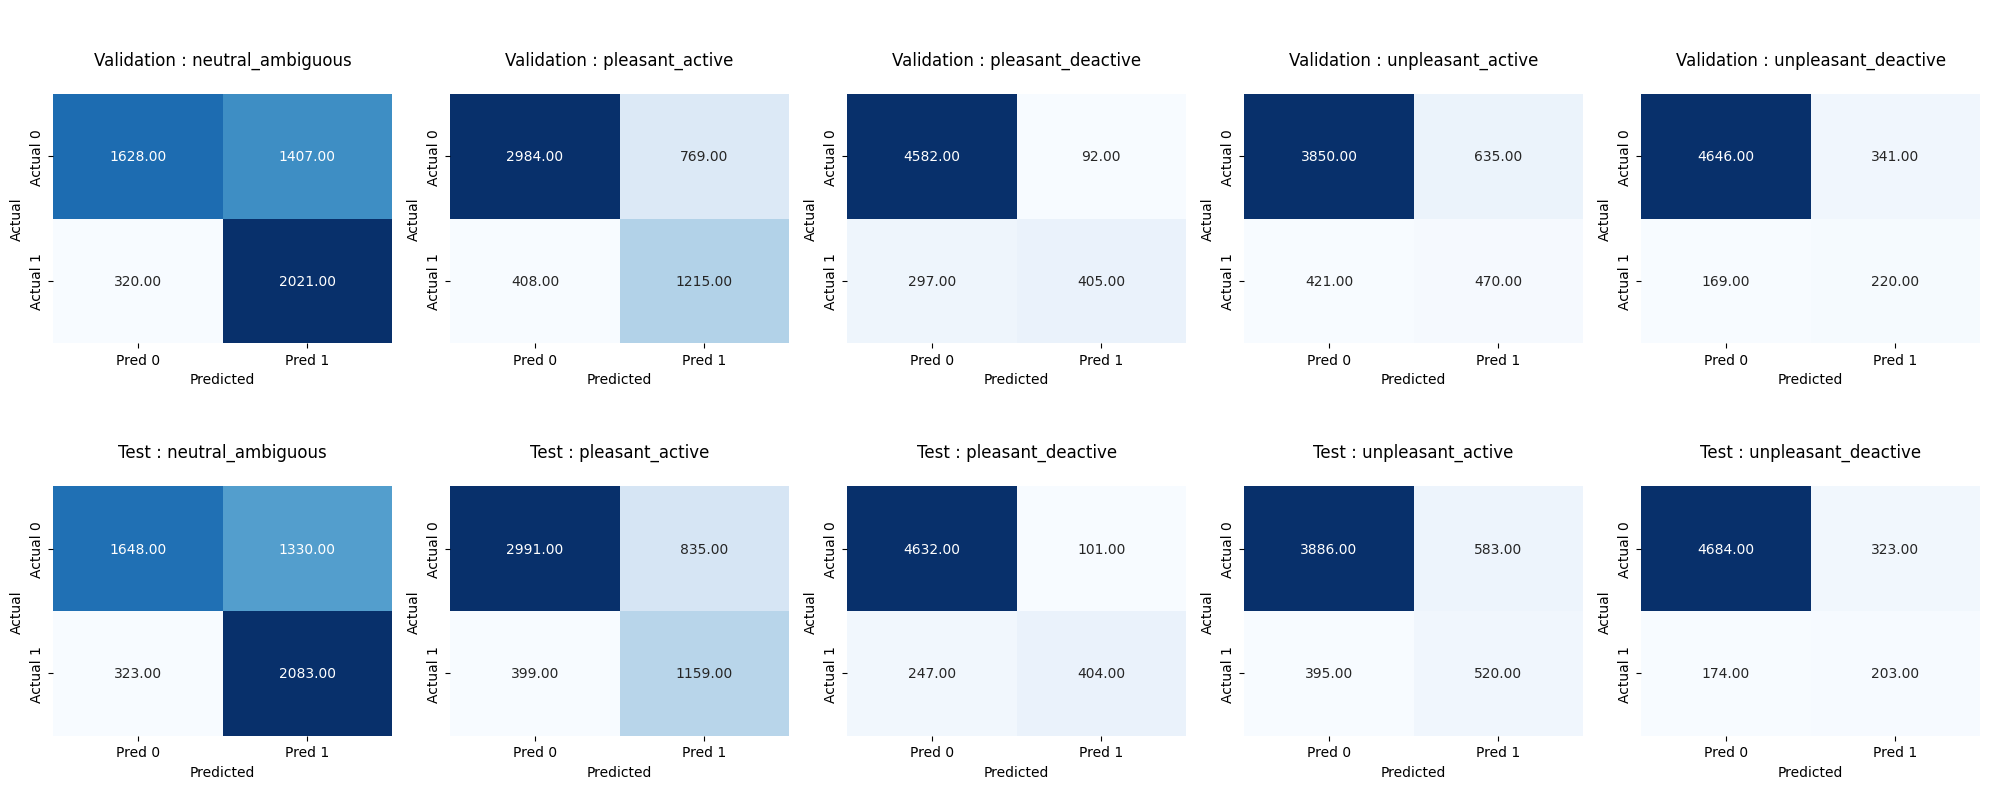

In [24]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_cat_svc, ts_quadrant, categories)

cm_test_svc_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_cat_svc,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_quadrant, cm_test_svc_quadrant, categories, normalize=False)

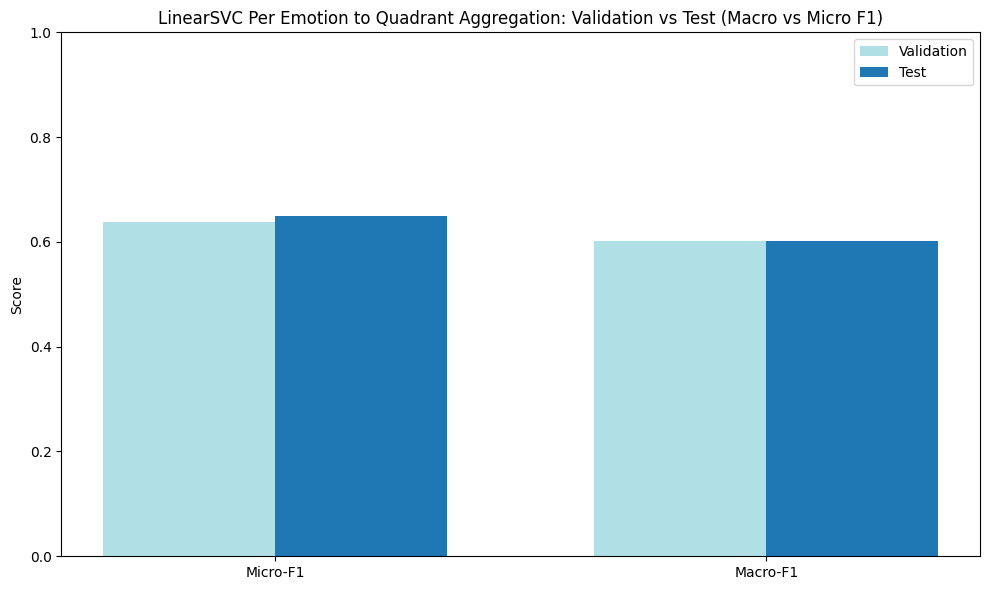

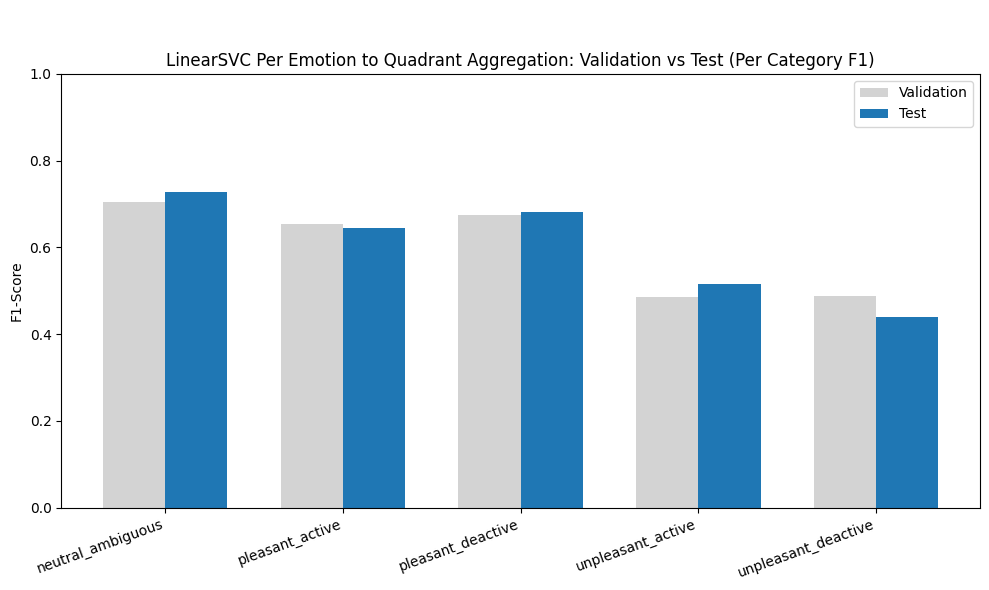

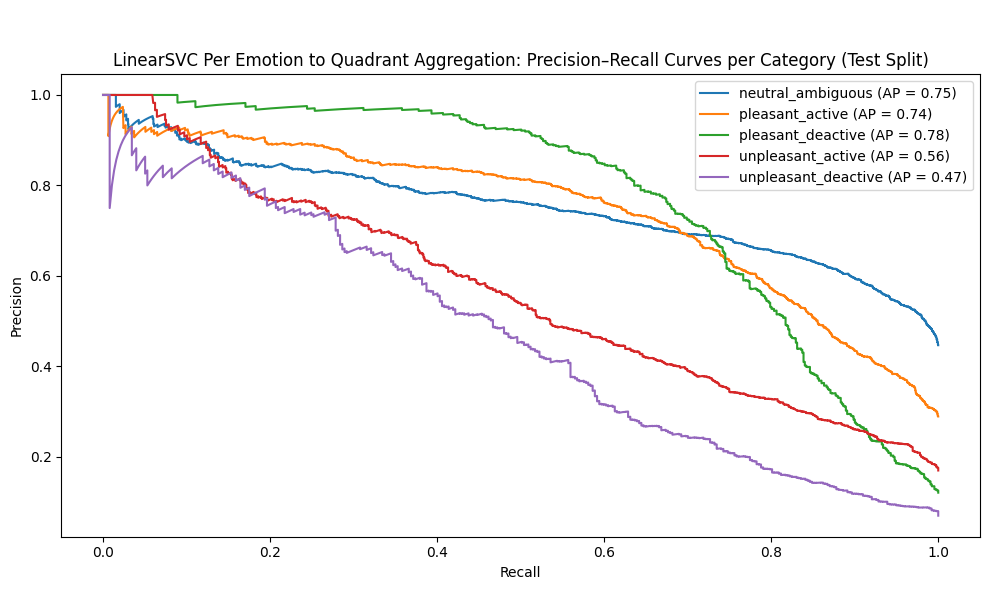

In [25]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_per_emo, test_metrics_svc_per_emo, model_name="LinearSVC Per Emotion to Quadrant Aggregation")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_per_emo, test_metrics_svc_per_emo, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

# 4.Transformer Models: BERT, RoBERTa

## 4.1. Install and Import Required Libraries

In [26]:
!pip -q install torch transformers==4.44.2 accelerate scikit-learn evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 128.5 MB/s eta 0:00:00


In [27]:
import evaluate
import itertools, math, random, gc, time, traceback

## 4.2.Set Seed for Reproducibility and Device Configuration

In [28]:
#ensure reproducibility across Python, NumPy, and PyTorch
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #select gpu if available else use cpu

## 4.3.Dataset Class for Transformers

In [29]:
#custom PyTorch dataset for multi-label emotion classification

class EmoDataset(Dataset):
  def __init__(self, texts, y, tok, max_len=80):
    self.texts=texts
    self.y=torch.tensor(y, dtype=torch.float32)
    self.tok=tok
    self.max_len=max_len

  #get the total num of texts in the dataset
  def __len__(self): return len(self.texts)

  def __getitem__(self, i):

    #tokenize one sentence at a time
    enc=self.tok(self.texts[i], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")

    #remove batch dimension added by the tokenizer
    item={k: v.squeeze(0) for k, v in enc.items()}

    #attach the corresponding multi-label target
    item["labels"]=self.y[i]
    return item

## 4.4.Loss Functions

In [30]:
#Asymmetric Loss (ASL) class
class AsymmetricLossClipped(nn.Module):

  def __init__(self, gamma_pos=1.0, gamma_neg=3, eps=0.04):
    super().__init__()
    self.gamma_pos=gamma_pos
    self.gamma_neg=gamma_neg
    self.eps=eps

  def forward(self, logits, y_true):
    #convert logits to probabilities using sigmoid
    y_hat=torch.sigmoid(logits)

    if self.eps>0:
      y_hat=y_hat.clamp(min=self.eps, max=1.0-self.eps) #clip to eps, (1-eps)

    #positive and negative sample losses
    pos_loss=-(y_true)*torch.log(y_hat)*torch.pow(1.0-y_hat, self.gamma_pos)
    neg_loss=-(1.0-y_true)*torch.log(1.0-y_hat)*torch.pow(y_hat, self.gamma_neg)

    #combine positive and negative losses and average across the batch
    loss=pos_loss+neg_loss
    return loss.sum()/logits.size(0)

#select and configure loss function
def get_criterion(loss, y_train, gamma_pos=1.0, gamma_neg=3, eps=0.04):

  #Asymmetric Loss
  if loss.lower()=="asl":
    return AsymmetricLossClipped(gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #Weighted Binary Cross-Entropy
  elif loss.lower()=="wbce":

    #count positive and negative occurrences per label
    pos_counts=y_train.sum(axis=0)+1e-6
    neg_counts=(y_train.shape[0]-pos_counts)+1e-6

    #assign higher weight to rarer positive labels
    pos_weight=torch.tensor(neg_counts/pos_counts, dtype=torch.float32).to(device)
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  else:
    raise ValueError(f"Unknown loss: {loss}")

## 4.5. Training and Evaluation

### 4.5.1. Single Configuration Training Runner

In [31]:
#runs one complete experiment: train, val-based threshold tuning, and test evaluation for a given configuration

#apply sigmoid and per-label thresholds
def apply_thresholds(logits, thresholds):
  probs=1/(1+np.exp(-logits))
  preds=(probs >= thresholds).astype(int)
  return preds, probs

def run_one_config(cfg):

  #extract hyperparameters for the current configuration
  model_name=cfg["model_name"]
  max_len=int(cfg["max_len"])
  batch_size=int(cfg["batch_size"])
  lr=float(cfg["lr"])
  epochs=int(cfg["epochs"])
  loss=cfg["loss"]
  gamma_pos=float(cfg["gamma_pos"])
  gamma_neg=float(cfg["gamma_neg"])
  eps=float(cfg["eps"])
  warmup_ratio=float(cfg["warmup_ratio"])
  weight_decay=float(cfg["weight_decay"])

  #load tokenizer for the selected transformer model
  tokenizer=AutoTokenizer.from_pretrained(model_name)

  #construct train, val, and test datasets
  train_ds=EmoDataset(X_train_transformer, y_train, tokenizer, max_len=max_len)
  val_ds=EmoDataset(X_val_transformer, y_val, tokenizer, max_len=max_len)
  test_ds=EmoDataset(X_test_transformer, y_test, tokenizer, max_len=max_len)

  #dynamically pad batches to the longest sequence in each batch
  collator=DataCollatorWithPadding(tokenizer)

  #load transformer model
  model=AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=y_train.shape[1], problem_type="multi_label_classification").to(device)

  #initialise loss function
  criterion=get_criterion(loss, y_train, gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #custom loss computation to integrate the selected criterion with Trainer
  def compute_loss(model, inputs, return_outputs=False,**kwargs):
    labels=inputs.pop("labels") #remove 'labels' from inputs dictionary
    outputs=model(**inputs)     #feed the remaining inputs to the model
    logits=outputs.logits       #extract the logits from model outputs
    loss=criterion(logits, labels.to(logits.dtype))  #compute the loss between predicted logits and true labels
    return (loss, outputs) if return_outputs else loss

  #training configuration for the current run
  args=TrainingArguments(
    output_dir=f"./emo-{model_name.split('/')[0]}/{int(time.time())}",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=max(16, batch_size),
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    lr_scheduler_type="linear",
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=["none"],
    save_total_limit=2
  )

  #initialise Trainer with early stopping
  trainer=Trainer(
      model=model,
      args=args,
      train_dataset=train_ds,
      eval_dataset=val_ds,
      tokenizer=tokenizer,
      data_collator=collator,
      callbacks=[
          EarlyStoppingCallback(
              early_stopping_patience=2,
              early_stopping_threshold=0.0
          )
      ]
  )

  #use custom loss function during training
  trainer.compute_loss=compute_loss

  #train the model
  trainer.train()

  #run validation inference and tune per-label decision thresholds
  val_out = trainer.predict(val_ds)
  val_logits = val_out.predictions
  ts_label=utils.best_thresholds_per_label(val_logits, y_val, n_grid=80, use_quantiles=False, scores_are_logits=True)
  val_preds_perlabel_tuned, val_probs_perlabel_tuned=apply_thresholds(val_logits, ts_label)
  val_macro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="macro", zero_division=0)
  val_micro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="micro", zero_division=0)

  #compute validation performance using a fixed 0.5 threshold baseline
  baseline_ts=utils.baseline_thresholds(y_val)
  val_preds_baseline_ts, val_probs_baseline=apply_thresholds(val_logits, baseline_ts)
  val_macro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="macro", zero_division=0)
  val_micro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="micro", zero_division=0)

  #run test inference using thresholds tuned on the validation set
  test_out = trainer.predict(test_ds)
  test_logits = test_out.predictions

  #evaluate on test set using thresholds derived from validation data
  test_preds_perlabel_tuned, test_probs_perlabel_tuned=apply_thresholds(test_logits, ts_label)
  test_macro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="macro", zero_division=0)
  test_micro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="micro", zero_division=0)

  test_preds_baseline_ts, test_probs_baseline_ts=apply_thresholds(test_logits, baseline_ts)
  test_macro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="macro", zero_division=0)
  test_micro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="micro", zero_division=0)

  #aggregate evaluation metrics and configuration details for this run
  result={
    "val_macro":float(val_macro_perlabel_tuned),
    "val_micro":float(val_micro_perlabel_tuned),
    "test_macro":float(test_macro_perlabel_tuned),
    "test_micro":float(test_micro_perlabel_tuned),

    "val_macro_0.5_ts":float(val_macro_baseline_ts),
    "val_micro_0.5_ts":float(val_micro_baseline_ts),
    "test_macro_0.5_ts":float(test_macro_baseline_ts),
    "test_micro_0.5_ts":float(test_micro_baseline_ts),

    "thresholds":ts_label,
    "cfg": cfg
  }

  #convert model outputs to NumPy arrays
  def _to_numpy(x):
      if hasattr(x, "detach"):
          x = x.detach().cpu().numpy()
      return np.asarray(x)

  val_logits_np  = _to_numpy(val_out.predictions)
  test_logits_np = _to_numpy(test_out.predictions)

  #store logits in the result dictionary
  result.update({
      "val_logits":  val_logits_np,
      "test_logits": test_logits_np,

  })

  #release resources before the next run
  del trainer, model
  torch.cuda.empty_cache()
  gc.collect()
  return result

### 4.5.2.Transformers Configurations Grid and Search Helper

In [32]:
#define experiment configurations for grid search across BERT and RoBERTa

#full grid used for preliminary hyperparameter exploration and selection
#grid_bert={
#    "model_name": ["bert-base-uncased"],
#    "loss": ["asl", "wbce"],
#    "gamma_pos": [1.0],
#    "gamma_neg": [3.0],
#    "eps":[0.03],
#    "lr":[1e-5, 3e-5, 5e-5],
#    "batch_size":[32],
#    "epochs":[4, 5, 6],
#    "max_len":[128],
#    "warmup_ratio":[0.06],
#    "weight_decay":[0.01]
#}

#grid_roberta={
#    "model_name": ["roberta-base"],
#    "loss": ["asl", "wbce"],
#    "gamma_pos": [1.0],
#    "gamma_neg": [3.0],
#    "eps":[0.03],
#    "lr":[1e-5, 3e-5, 4e-5, 5e-5],
#    "batch_size":[32, 64],
#    "epochs":[4, 5, 6],
#    "max_len":[128, 256],
#    "warmup_ratio":[0.06],
#    "weight_decay":[0.01]
#}

#BERT Base Configuration
grid_bert={
    "model_name": ["bert-base-uncased"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[32],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#RoBERTa Base Configuration
grid_roberta={
    "model_name": ["roberta-base"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[64],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#generate all hyperparameter combinations
def dict_product(d):
  keys=list(d.keys())
  for values in itertools.product(*(d[k] for k in keys)):
    yield dict(zip(keys, values))

#generate configurations for each model
cfgs_bert=list(dict_product(grid_bert))
cfgs_roberta=list(dict_product(grid_roberta))

#combine model identifiers with their respective configurations
experiment_cfgs=[("bert-base-uncased", cfg) for cfg in cfgs_bert] + [("roberta-base", cfg) for cfg in cfgs_roberta]

### 4.5.3.Experiment Execution

In [33]:
#run grid search experiments, track the best configuration per model, and select overall best model based on val macro-F1

best_per_model={} #store best result per model
history=[]        #store results from all runs

#iterate over all experiment configurations
for i, (model_key, cfg) in enumerate(experiment_cfgs, 1):
    print(f"\n[{i}/{len(experiment_cfgs)}] Running {model_key} with cfg: {cfg}")
    try:
        set_seed(42)
        result=run_one_config(cfg)
        history.append(result)
        model_name= cfg["model_name"]

        #update best result for the current model based on val macro-F1
        if model_name not in best_per_model:
          best_per_model[model_name]=result
        else:
          if result["val_macro"] > best_per_model[model_name]["val_macro"]:
            best_per_model[model_name]=result
        print(f"{model_name}: Val macro-F1={result['val_macro']:.4f}, micro-F1={result['val_micro']:.4f}")

    #handle runtime errors
    except RuntimeError as e:
        msg = str(e)
        print("RuntimeError:", msg)
        if "CUDA out of memory" in msg:
            print("GPU Out of Memory")
        else:
            traceback.print_exc()

    except Exception as e:
        print("Exception:", e)
        traceback.print_exc()

    #release gpu memory after each run
    finally:
        torch.cuda.empty_cache(); gc.collect()

#report the best configuration per model
print("\nPer model best results\n")
for model_name, res in best_per_model.items():
  print("Model:", model_name)
  print("Best Configuration:", res['cfg'])
  print(f"Val  macro-F1 using per-label threshold {res['val_macro']:.4f} | micro-F1 {res['val_micro']:.4f}")
  print(f"Test macro-F1 using per-label threshold {res['test_macro']:.4f} | micro-F1 {res['test_micro']:.4f}")
  print(f"Val  macro-F1 using a fixed 0.5 threshold {res['val_macro_0.5_ts']:.4f} | micro-F1 {res['val_micro_0.5_ts']:.4f}")
  print(f"Test macro-F1 using a fixed 0.5 threshold {res['test_macro_0.5_ts']:.4f} | micro-F1 {res['test_micro_0.5_ts']:.4f}")
  print("_"*70)

#select and report the overall best configuration across all models
overall_best=max(best_per_model.values(), key=lambda r: r["val_macro"])
print("\nOverall best across models\n")
print("Best cfg:", overall_best['cfg'])
print(f"Val  macro-F1 using per-label threshold {overall_best['val_macro']:.4f} | micro-F1 {overall_best['val_micro']:.4f}")
print(f"Test macro-F1 using per-label threshold {overall_best['test_macro']:.4f} | micro-F1 {overall_best['test_micro']:.4f}")
print(f"Val  macro-F1 using a fixed 0.5 threshold {overall_best['val_macro_0.5_ts']:.4f} | micro-F1 {overall_best['val_micro_0.5_ts']:.4f}")
print(f"Test macro-F1 using a fixed 0.5 threshold {overall_best['test_macro_0.5_ts']:.4f} | micro-F1 {overall_best['test_micro_0.5_ts']:.4f}")


[1/2] Running bert-base-uncased with cfg: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.655200,0.631514
2,0.563200,0.626366
3,0.426600,0.693028
4,0.330400,0.783040


bert-base-uncased: Val macro-F1=0.5581, micro-F1=0.6173

[2/2] Running roberta-base with cfg: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.680600,0.645767
2,0.593500,0.621932
3,0.523900,0.633436
4,0.456600,0.659352


roberta-base: Val macro-F1=0.5516, micro-F1=0.6153

Per model best results

Model: bert-base-uncased
Best Configuration: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5581 | micro-F1 0.6173
Test macro-F1 using per-label threshold 0.5279 | micro-F1 0.6014
Val  macro-F1 using a fixed 0.5 threshold 0.5076 | micro-F1 0.6166
Test macro-F1 using a fixed 0.5 threshold 0.5097 | micro-F1 0.6145
______________________________________________________________________
Model: roberta-base
Best Configuration: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5516 | micro-F1 0.6153
Test macro-F1 using per-label thresh

## 4.6. Quadrant-Level Evaluation

In [34]:
#convert best model's logits to probabilities using sigmoid
val_probs_emo=1/(1+np.exp(-overall_best["val_logits"]))
test_probs_emo=1/(1+np.exp(-overall_best["test_logits"]))

emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert emotion-level labels to category-level labels (4 emotion quadrants)
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

In [35]:
#convert emotion-level probabilities to category-level probabilities using noisy-or aggregation
val_scores_cat = utils.probs_emo_to_cat(val_probs_emo, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat = utils.probs_emo_to_cat(test_probs_emo, categories, cat_to_emoIds, mode="noisy_or")

#compute optimal decision thresholds for each category using val data
ts_cat=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate category-level model performance on val and test sets
val_metrics=utils.evaluate_run(y_val_cat, val_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation \nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_scores_cat, ts_baseline, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation \nFixed 0.5 Threshold")

test_metrics=utils.evaluate_run(y_test_cat, test_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation \nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_test_cat, test_scores_cat, ts_baseline, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation \nFixed 0.5 Threshold")


Best Transformer (Val Split): Quadrant-Level Evaluation 
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.74
Macro F1: 0.72

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.68      0.86      0.76      2341
    pleasant_active       0.72      0.83      0.77      1623
  pleasant_deactive       0.83      0.72      0.77       702
  unpleasant_active       0.60      0.71      0.65       891
unpleasant_deactive       0.67      0.60      0.63       389

          micro avg       0.69      0.80      0.74      5946
          macro avg       0.70      0.75      0.72      5946
       weighted avg       0.69      0.80      0.74      5946
        samples avg       0.74      0.82      0.75      5946


Best Transformer (Val Split): Quadrant-Level Evaluation 
Fixed 0.5 Threshold
Micro F1: 0.44
Macro F1: 0.41

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambig

In [36]:
#convert per-emotion probabilities to per-category probabilities using max aggregation
val_scores_cat_max = utils.probs_emo_to_cat(val_probs_emo, categories, cat_to_emoIds, mode="max")
test_scores_cat_max = utils.probs_emo_to_cat(test_probs_emo, categories, cat_to_emoIds, mode="max")

#compute optimal decision thresholds for each category using val data
ts_cat=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#evaluate category-level model performance on val and test sets
print("\n Category-Level Val\n")
utils.evaluate_run(y_val_cat, val_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation \nPer-label Thresholds with max Aggregation\n", return_metrics=True)

print("\n Category-Level Test\n")
utils.evaluate_run(y_test_cat, test_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation \nPer-label Thresholds with max Aggregation\n", return_metrics=True)


 Category-Level Val


Best Transformer (Val Split): Quadrant-Level Evaluation 
Per-label Thresholds with max Aggregation

Micro F1: 0.74
Macro F1: 0.72

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.68      0.86      0.76      2341
    pleasant_active       0.72      0.83      0.77      1623
  pleasant_deactive       0.83      0.72      0.77       702
  unpleasant_active       0.60      0.71      0.65       891
unpleasant_deactive       0.67      0.60      0.63       389

          micro avg       0.69      0.80      0.74      5946
          macro avg       0.70      0.75      0.72      5946
       weighted avg       0.69      0.80      0.74      5946
        samples avg       0.74      0.82      0.75      5946


 Category-Level Test


Best Transformer (Test Split): Quadrant-Level Evaluation 
Per-label Thresholds with max Aggregation

Micro F1: 0.74
Macro F1: 0.71

Detailed Classification Report:
             

{'micro-f1': 0.737121863519112,
 'macro-f1': 0.7065738977608337,
 'micro-precision': 0.6847226256171943,
 'micro-recall': 0.79820551887591,
 'per_label_f1': array([0.77028276, 0.75981254, 0.77604594, 0.64122894, 0.58549932]),
 'per_label_precision': array([0.69351082, 0.69881466, 0.83274648, 0.58658205, 0.60451977]),
 'per_label_recall': array([0.86616791, 0.83247754, 0.7265745 , 0.70710383, 0.56763926])}

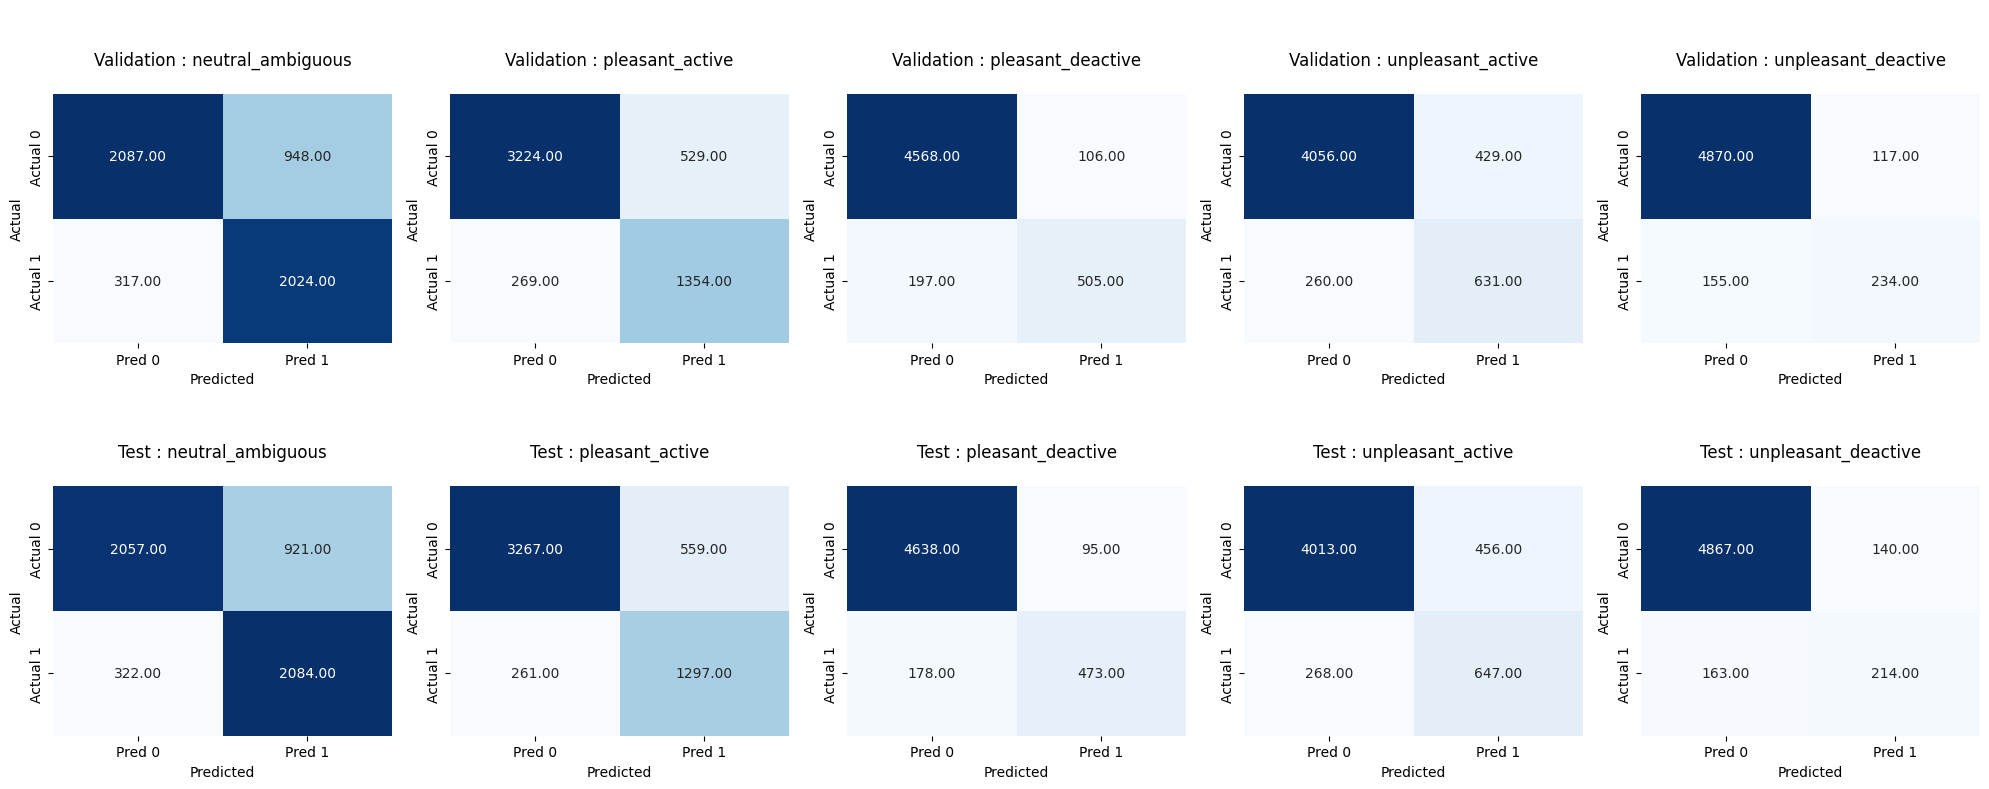

In [37]:
#compute per-category confusion matrices for val and test splits
cm_val_transformer=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_cat, categories)

cm_test_transformer=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_cat, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_transformer, cm_test_transformer, categories, normalize=False)

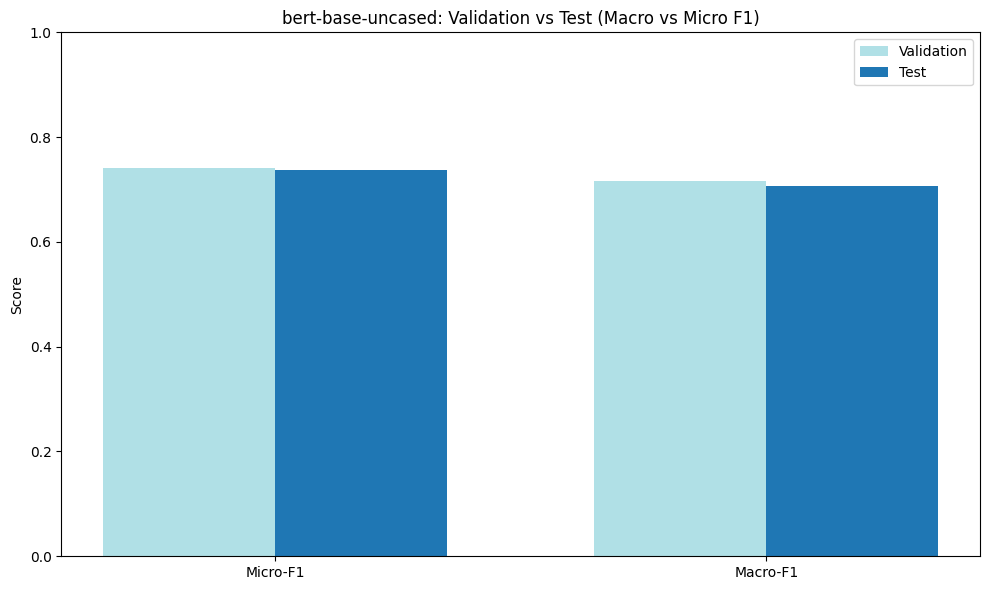

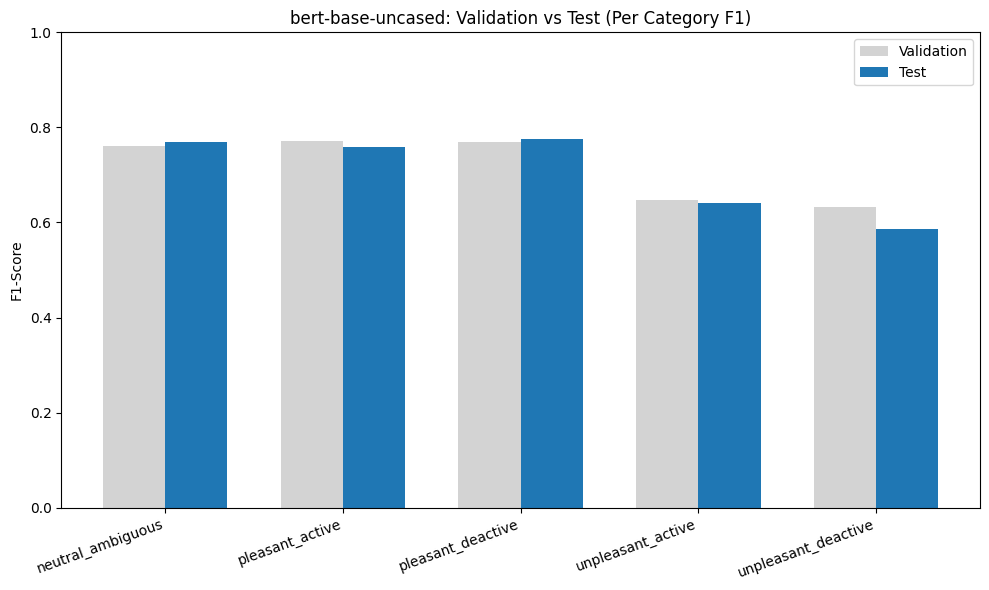

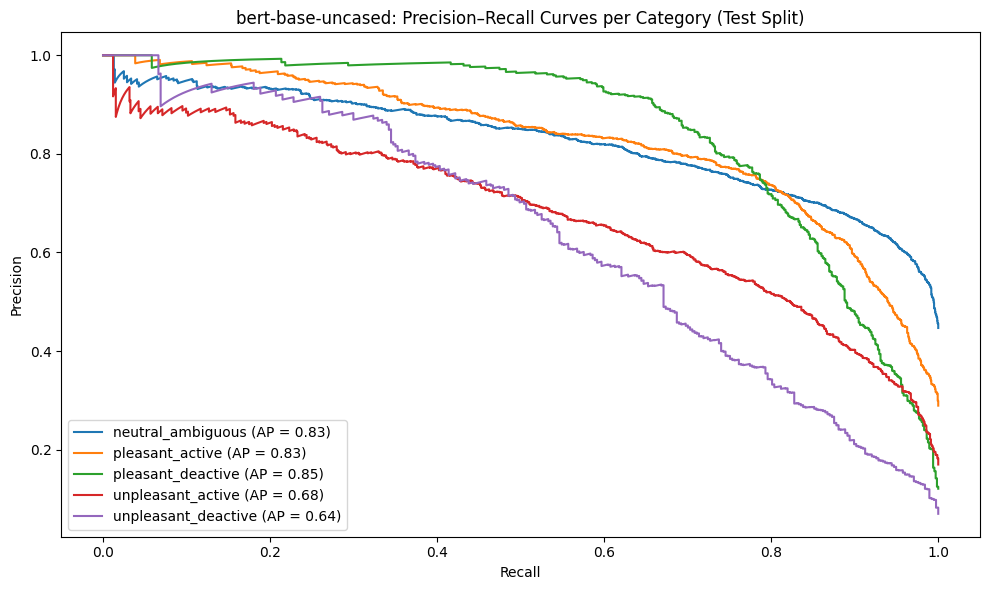

In [38]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics, test_metrics, model_name=overall_best["cfg"]["model_name"])

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name=overall_best["cfg"]["model_name"])

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name=overall_best["cfg"]["model_name"])

# 5.Map Burnout Indicators from Predicted Quadrants

In [39]:
#determine a burnout-related indicator from quadrant-level predictions using rule-based priority scheme

def burnout_indicator_from_quadrants(pred_row, col_idx):

  #extract binary predictions for each affective quadrant
  NEU=int((pred_row[col_idx["neutral_ambiguous"]]))
  PA=int((pred_row[col_idx["pleasant_active"]]))
  PD=int((pred_row[col_idx["pleasant_deactive"]]))
  NA=int((pred_row[col_idx["unpleasant_active"]]))
  ND=int((pred_row[col_idx["unpleasant_deactive"]]))

  #assign a burnout-related indicator using a rule-based priority
  if ND:
    return "Signs of Advanced Burnout (Exhaustion/Ineffectiveness)"
  elif NA:
    return "Signs of Moderate Burnout (Stress/Cynicism)"
  elif PA:
    return "Indicators of Engagement (No Apparent Signs of Burnout)"
  elif PD:
    return "Indicators of Satisfaction (No Apparent Signs of Burnout)"
  elif NEU:
    return "Ambiguous Burnout Indicator"
  else:
    return "Ambiguous Burnout Indicator"

In [40]:
#convert category probabilities to binary predictions using per-label thresholds
preds_cat = (test_scores_cat >= ts_cat).astype(int)

#map quadrant names to their corresponding column indices
col_idx = {c:i for i,c in enumerate(categories)}

#generate burnout-related indicator for each test
labels = [burnout_indicator_from_quadrants(row, col_idx) for row in preds_cat]

In [41]:
#summarise distribution of burnout-related indicators across the test set
pd.Series(labels).value_counts()

,count
Ambiguous Burnout Indicator,1878
Indicators of Engagement (No Apparent Signs of Burnout),1765
Signs of Moderate Burnout (Stress/Cynicism),1023
Indicators of Satisfaction (No Apparent Signs of Burnout),364
Signs of Advanced Burnout (Exhaustion/Ineffectiveness),354
